# USA Politician Twitter Classification with LSTM NN

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/democratvsrepublicantweets/ExtractedTweets.csv
/kaggle/input/democratvsrepublicantweets/TwitterHandles.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import keras
import copy
import string
import copy

In [4]:
tweets_reader=pd.read_csv("/kaggle/input/democratvsrepublicantweets/ExtractedTweets.csv",chunksize=1000)
users_df=pd.read_csv("/kaggle/input/democratvsrepublicantweets/TwitterHandles.csv")


In [6]:

word_cts_df=pd.DataFrame()
handles_df=pd.DataFrame(columns=["Party"])
tweets_reader=pd.read_csv("/kaggle/input/democratvsrepublicantweets/ExtractedTweets.csv",chunksize=1000)
for i,chunk in enumerate(tweets_reader):
    #if i>10:
        #break
    chunk["Text"]=chunk["Tweet"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())
    chunk["Tokenized"]=chunk["Text"].apply(lambda x: x.split(" "))
    corpus = list(chunk["Text"])
    handles1_df=chunk.drop_duplicates(subset=["Handle"])[["Handle","Party"]]
    handles1_df.index=handles1_df.Handle
    handles1_df=handles1_df["Party"]
    handles_df.append(handles1_df)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    chunk_freq=np.sum(X.toarray(),0)
    c=pd.Series(chunk_freq)
    c.index=pd.Series(vectorizer.get_feature_names())
    chunk_cts_df=pd.DataFrame(columns=["Count"],data={"Count":c},
                              index=pd.Series(vectorizer.get_feature_names()))
    word_cts_df=word_cts_df.add(chunk_cts_df,fill_value=0)
    if len(word_cts_df)>100000:
        word_cts_df=word_cts_df.sort_values("Count",ascending=False)
        word_cts_df=word_cts_df.iloc[range(20000)]
    #if i>=50:
        #break
    
    
tweets_reader.close()
old_cts_df=copy.copy(word_cts_df)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


In [7]:
handles_df=pd.read_csv("/kaggle/input/democratvsrepublicantweets/ExtractedTweets.csv")\
.drop_duplicates(subset=["Handle"])
handles_df.index=handles_df.Handle
handles_df=handles_df[["Party"]]
len(handles_df)

433

# We only want to use a subset of most common words

In [12]:
N_words=2000
word_cts_df=old_cts_df.sort_values("Count",ascending=False)
word_cts_df=word_cts_df.iloc[range(N_words)]
word_cts_df

,Count
the,71507.0
to,57616.0
of,31373.0
and,30148.0
in,26060.0
...,...
ed,83.0
unfortunately,83.0
talented,83.0
usnavy,83.0


# Apply function to tokenized vect that grows tweet to a fixed length adding "?" + replace removed words with string of "?"

In [13]:
def filter_tweet(tweet_tok,words_index):
    return(list(map (lambda w:w if w in words_index else '?',tweet_tok)))
def vectorize_tweet(tweet_tok,words_index,max_words,sentence_length):
    tweet_list=list(map (lambda w:list(words_index).index(w) 
                     if w in words_index else max_words,tweet_tok))
    if len(tweet_list)>sentence_length:
        tweet_list=tweet_list[:sentence_length]
    if len(tweet_list)<sentence_length:
        tweet_list+=(sentence_length-len(tweet_list))*[max_words]
    return(np.array(tweet_list))

print(filter_tweet(chunk["Tokenized"].iloc[100],word_cts_df.index))
test_tok=copy.copy(chunk["Tokenized"].iloc[100])
#test_tok+=5*["the"]+100*["national"]
vec_test=vectorize_tweet(test_tok,word_cts_df.index,N_words,20)
print(vec_test,"Length:",len(vec_test))
print(chunk["Tokenized"].iloc[100])
#chunk["Tokenized"]
#"www" in word_cts_df.index # Now we have the first 1000 words
word_cts_df.index

['rt', '?', 'breaking', 'the', 'trump', 'admin', 'is', 'moving', 'the', 'country', 'closer', 'to', 'opening', 'the', '?', 'to', '?', 'dems', 'sent', '?', 'letter', 'to', '?']
[   6 2000  445    0   48  912    8  970    0  102 1491    1  587    0
 2000    1 2000 1110  551 2000] Length: 20
['rt', 'nrdems', 'breaking', 'the', 'trump', 'admin', 'is', 'moving', 'the', 'country', 'closer', 'to', 'opening', 'the', 'arcticrefuge', 'to', 'drilling\n\nhouse', 'dems', 'sent', 'a', 'letter', 'to', '…']


Index(['the', 'to', 'of', 'and', 'in', 'for', 'rt', 'on', 'is', 'our',
       ...
       'dinner', 'repcohen', 'harmful', 'eastern', 'tonights', 'ed',
       'unfortunately', 'talented', 'usnavy', 'nebraska'],
      dtype='object', length=2000)

In [14]:
# Now lets tokenize the tweets, then use the words to look up in table and return "?" if nothing.
tweets_reader=pd.read_csv("/kaggle/input/democratvsrepublicantweets/ExtractedTweets.csv",chunksize=1000)
sentence_length=20
handle_seq=pd.Series()
vec_data=[]
classes=[]
for i,chunk in enumerate(tweets_reader):
    print(i)
    chunk["Text"]=chunk["Tweet"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())
    chunk["Tokenized"]=chunk["Text"].apply(lambda x: x.split(" "))
    chunk["Replaced"]=chunk["Tokenized"].apply(lambda x: filter_tweet(x,word_cts_df.index))
    chunk["Vectorized"]=chunk["Tokenized"].apply(lambda x: vectorize_tweet(x,word_cts_df.index,
                                                                           N_words,sentence_length))
    
    handle_seq=handle_seq.append(chunk["Handle"])
    vec_data+=list(chunk["Vectorized"])
    corpus = list(chunk["Text"])
    vectorizer = CountVectorizer()
    classes+=list(chunk["Party"]=="Democrat")
    X = vectorizer.fit_transform(corpus)
    
    # Lets also append a list of all the handles together so we can 
    #if i>=1000:
        #break


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


In [15]:
old_vec_data=np.array(vec_data)
old_classes=np.array(classes)
vec_data=np.array(vec_data)
classes=np.array(classes)
rand_perm=np.random.permutation(len(vec_data))
vec_data=vec_data[rand_perm,:]
classes=classes[rand_perm]
input_train=vec_data[:int(.8*np.floor(len(vec_data))),:]
y_train=classes[:int(np.floor(.8*len(vec_data)))]


In [16]:
input_test=vec_data[int(.8*np.floor(len(vec_data))):,:]
y_test=classes[int(np.floor(.8*len(vec_data))):]

In [17]:
len(classes)

86460

# Definition of LSTM with embedding
# Low complexity model does a good job if we have ~5000 words: ~77% classification

# Retaining 2000 words gives us approximately 70%

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()

model.add(Embedding(N_words+1,128))
model.add(LSTM(8))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

In [34]:
history = model.fit(input_train, y_train,
                   epochs=1,
                    batch_size=128,
                    validation_split=.25)

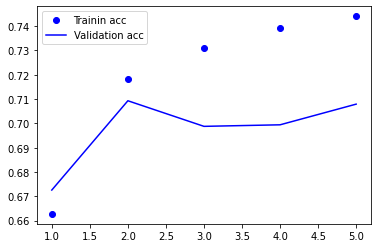

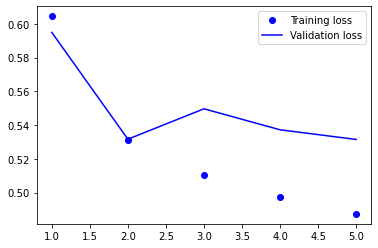

In [21]:
from matplotlib import pyplot as plt
acc =  history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Trainin acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

In [22]:
results = model.evaluate(input_test, y_test, batch_size=128)
print("test loss, test acc:", results)

136/136 [==============================] - 0s 3ms/step - loss: 0.6148 - acc: 0.6985
test loss, test acc: [0.6148239970207214, 0.6985310912132263]


In [25]:
# Now lets withold some accounts from the training and validating to see if we can accurately 
users_df=pd.read_csv("/kaggle/input/democratvsrepublicantweets/TwitterHandles.csv")

In [26]:
import pandas as pd
handles_df=pd.read_csv("/kaggle/input/democratvsrepublicantweets/ExtractedTweets.csv")\
.drop_duplicates(subset=["Handle"])
handles_df.index=handles_df.Handle
handles_df=handles_df[["Party"]]


# pick a politician from handles df
p_ind=list(np.random.choice(len(handles_df),12))

handle_seq

old_vec_data
old_classes
import functools
test_set_bool=functools.reduce( lambda x,y: x|y,[handle_seq==handles_df.iloc[i].name for i in p_ind])
test_input=old_vec_data[test_set_bool,:]
y_test=old_classes[test_set_bool]

train_input=old_vec_data[~test_set_bool,:]
y_train=old_classes[~test_set_bool]
#[handle_seq==handles_df.iloc[i].name for i in p_ind]
len(y_test)
len(test_input)
len(y_train)
#len(old_classes)

84261

In [27]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from keras.layers import LSTM

model2 = Sequential()

model2.add(Embedding(N_words+1,256))
model2.add(LSTM(8))
model2.add(Dense(8,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

In [33]:
rand_perm=np.random.permutation(len(y_train))
history = model2.fit(train_input[rand_perm,:], y_train[rand_perm],
                   epochs=1,
                    batch_size=128,
                    validation_split=.2)

527/527 [==============================] - 6s 10ms/step - loss: 0.4623 - acc: 0.7650 - val_loss: 0.4970 - val_acc: 0.7376


In [30]:
predictions=model2.predict(test_input)


In [31]:
from matplotlib import pyplot as plt
tweets_df=pd.read_csv("/kaggle/input/democratvsrepublicantweets/ExtractedTweets.csv")


# ROC Curve of held out politicians

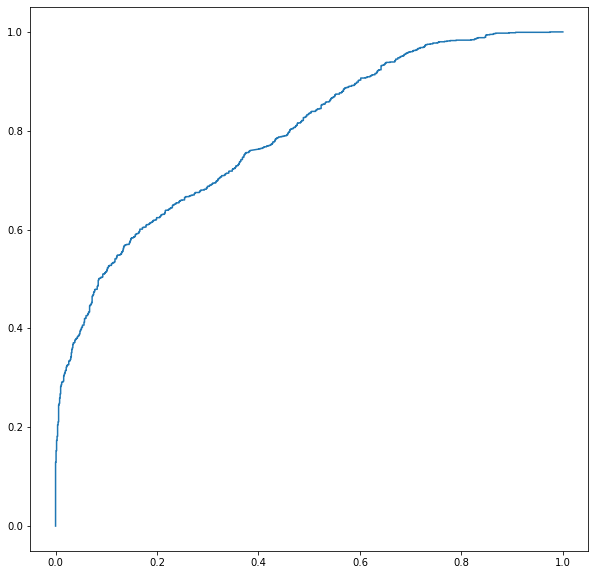

In [32]:
from sklearn.metrics import roc_curve, auc
y_score=predictions
fpr, tpr, thresholds=roc_curve(y_test,predictions)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
#plt.plot([0,1],[0,1])
#fpr